# **Importing the libraries**

In [2]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

# **Loading the Images**

In [3]:
X_train = []
Y_train = []

for i in tqdm(glob('/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Train/Mask/*')):
    temp = np.array(Image.open(i).resize((48,48)))
    X_train.append(temp)
    Y_train.append(1)
    
for i in tqdm(glob('/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Train/Non Mask/*')):
    temp = np.array(Image.open(i).resize((48,48)))
    X_train.append(temp)
    Y_train.append(0)    

100%|██████████| 300/300 [00:02<00:00, 100.01it/s]


In [4]:
X_test = []
Y_test = []

for i in tqdm(glob('/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Mask/*')):
    temp = np.array(Image.open(i).resize((48,48)))
    X_test.append(temp)
    Y_test.append(1)
    
for i in tqdm(glob('/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Validation/Non Mask/*')):
    temp = np.array(Image.open(i).resize((48,48)))
    X_test.append(temp)
    Y_test.append(0) 

100%|██████████| 153/153 [00:03<00:00, 48.22it/s]


# **Normalizing the images (with any algorithm)**

In [6]:
X_train = np.array(X_train)
X_train = X_train/255.0
Y_train = np.array(Y_train)
X_test = np.array(X_test)
X_test = X_test/255.0
Y_test = np.array(Y_test)

# **Normalizing the images using Min-Max Scaling algorithm**

In [62]:
#X = (np.array(X) - np.min(X)) / (np.max(X) - np.min(X))
#X = X/255.0
#Y = (np.array(Y) - np.min(Y)) / (np.max(Y) - np.min(Y))

# **Normalizing the images using Z-Score algorithm**

In [ ]:
# 'X = (np.array(X) - np.mean(X)) / np.std(X)
# X = X/255.0
# Y = (np.array(Y) - np.mean(Y)) / np.std(Y)'

# Expanding the dimensions of array (numpy)

In [9]:
X = np.expand_dims(X,-1)

# Spliting the dataset into training and testing data

In [65]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# CNN Model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

# Define the model
model = Sequential(name='DCNN')

model.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=(48, 48, 3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )
)
model.add(BatchNormalization(name='batchnorm_1'))
model.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )
)
model.add(BatchNormalization(name='batchnorm_2'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model.add(Dropout(0.4, name='dropout_1'))

model.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )
)
model.add(BatchNormalization(name='batchnorm_3'))
model.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )
)
model.add(BatchNormalization(name='batchnorm_4'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
model.add(Dropout(0.4, name='dropout_2'))

model.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )
)
model.add(BatchNormalization(name='batchnorm_5'))
model.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )
)
model.add(BatchNormalization(name='batchnorm_6'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model.add(Dropout(0.5, name='dropout_3'))

model.add(Flatten(name='flatten'))

model.add(
    Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense_1'
    )
)
model.add(BatchNormalization(name='batchnorm_7'))

model.add(Dropout(0.6, name='dropout_4'))

model.add(
    Dense(
        1,
        activation='sigmoid',
        name='out_layer'
    )
)

model.summary()


Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

# Compiling the Model

In [8]:
model.compile(loss='binary_crossentropy',optimizer='Nadam', metrics=['accuracy'])

In [9]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [10]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

# Training of the Model

In [11]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100

history = model.fit_generator(
    train_datagen.flow(X_train, Y_train, batch_size=batch_size),
    validation_data=(X_test, Y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100


2024-02-01 08:01:30.404895: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDCNN/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - 23s 102ms/step - loss: 0.8105 - accuracy: 0.7133 - val_loss: 1.3427 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 1s 40ms/step - loss: 0.5625 - accuracy: 0.7967 - val_loss: 4.2637 - val_accuracy: 0.5327 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 1s 44ms/step - loss: 0.4345 - accuracy: 0.8400 - val_loss: 1.6582 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 1s 49ms/step - loss: 0.4451 - accuracy: 0.8250 - val_loss: 1.0967 - val_accuracy: 0.7614 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 1s 51ms/step - loss: 0.3945 - accuracy: 0.8550 - val_loss: 1.5175 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 1s 48ms/step - loss: 0.3083 - accuracy: 0.8700 - val_loss: 1.2391 - val_accuracy: 0.7908 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 1s 43ms/step - loss: 0.3277

# Model Evaluation

In [12]:
model.evaluate(X_test, Y_test)

10/10 [==============================] - 0s 11ms/step - loss: 0.1825 - accuracy: 0.9542


[0.18245208263397217, 0.9542483687400818]

# Loading the Model Performance

In [ ]:
from keras.models import load_model
best_model = load_model('/kaggle/working/bestModel.h5')
best_model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 384ms/step


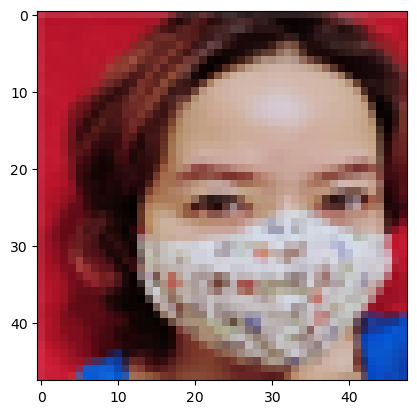

Mask
1/1 [==============================] - 0s 22ms/step


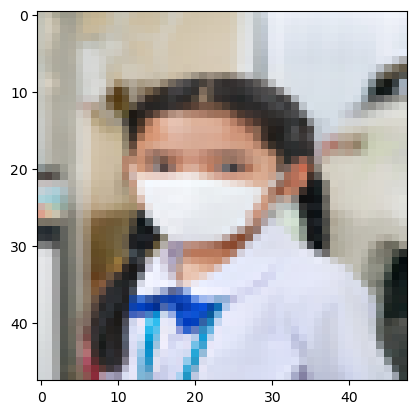

Mask
1/1 [==============================] - 0s 21ms/step


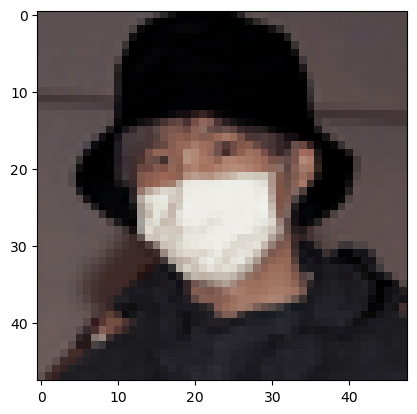

Mask
1/1 [==============================] - 0s 22ms/step


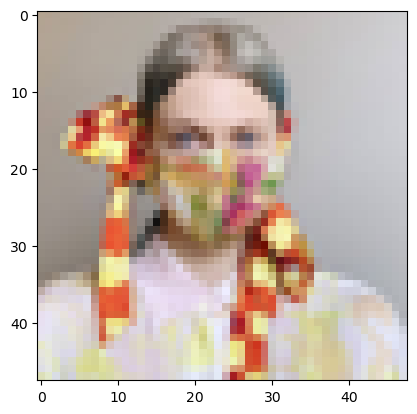

Mask
1/1 [==============================] - 0s 22ms/step


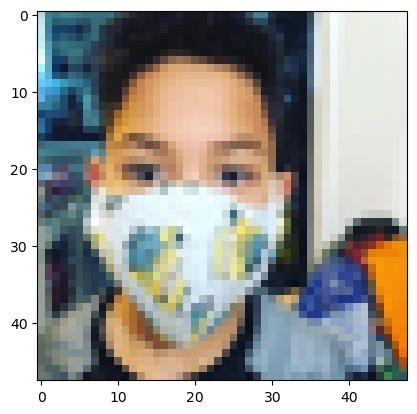

Mask
1/1 [==============================] - 0s 21ms/step


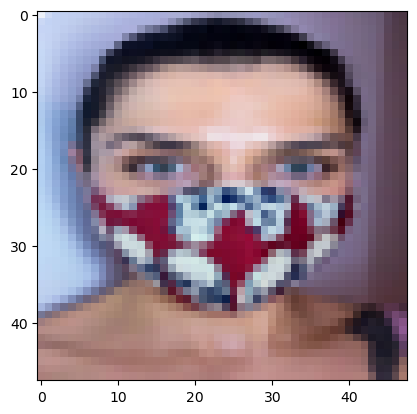

Mask


In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Loop through the first 5 images in x_test
for i in X_test[12:18]:
    # Resize the image to 48x48 pixels
    i_resized = cv2.resize(i, (48, 48))

    # Expand dimensions to add batch dimension
    i_expanded = np.expand_dims(i_resized, axis=0)

    # Perform prediction
    result = model.predict(i_expanded)

    # Plot the image
    plt.imshow(i_resized)
    plt.show()

    # Perform action based on prediction result
    if result > 0.5:
        print('Mask')
    else:
        print("No Mask")

# Changing the dimensions and Plotting the trained images

In [16]:
import cv2
import numpy as np

# Load the image
img_path = '/kaggle/input/covid-face-mask-detection-dataset/New Masks Dataset/Test/Non Mask/real_01038.jpg'
img = cv2.imread(img_path)

# Resize the image to 48x48 pixels
img_resized = cv2.resize(img, (48, 48))

# Convert the image to RGB (assuming it's in BGR format)
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

# Normalize the pixel values to the range [0, 1]
img_normalized = img_rgb / 255.0

# Add batch dimension to the image
img_with_batch = np.expand_dims(img_normalized, axis=0)

# Perform prediction using the image with batch dimension
result = model.predict(img_with_batch)

if result > 0.5:
    print('Masked')
else:
    print("No Mask")

1/1 [==============================] - 0s 22ms/step
No Mask


In [17]:
model.save('Masks.h5')

# Prediction and Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Accuracy

Evaluating the Accuracy

In [ ]:
accuracy = best_model.evaluate(x_test, y_test)[1]
print("Accuracy:", accuracy)